In [285]:
# Installs all used packages in our report
# install.packages("corrplot")
# install.packages("dplyr")
# install.packages("stargazer")
# install.packages("ggplot2")
# install.packages("reshape2")
# install.packages("tidyr")
# install.packages("broom")

# Loads packages
library('effsize')
library('dplyr')
library('ggplot2')
library('corrplot')
library('stargazer')

## Introduction
In this report we will discuss determinats of crime in North Carolina to help us generate policy suggestions for local government officals within the state. The data used in our analysis is a cross-section of data from a study by Cornwell and Trumball, researchers from the University of Georgia and West Virginia University. 

We believe local political figures in North Carolina are most interested in lowering the number of crimes in their respective counties. As a result, we will be focusing our models on the **crmrte** variable, that provides details on the crimes committed per person. 

## Omitted Variables
1. Urban: strongly correlated with density
2. Wage variables: correlated with each other, except wsta (average weekly wage of state employees). Decided to make one wage variable that is a sum of all of the individual wages


1. Weighting for Wages
2. Tax Revenue - how is it calculated
3. Education
4. Outreach/Social Programs
5. How do you define Urban? 
6. 

In [286]:
# Imports Data
dfCrime = read.csv("crime_v2.csv")

variable  | label
----------|------
1    county|               county identifier
2      year|                            1987
3    crmrte|     crimes committed per person
4    prbarr|         'probability' of arrest
5   prbconv|     'probability' of conviction
6   prbpris| 'probability' of prison sentence
7    avgsen|             avg. sentence, days
8     polpc|               police per capita
9   density|             people per sq. mile
10    taxpc|          tax revenue per capita
11     west|           =1 if in western N.C.
12  central|           =1 if in central N.C.
13    urban|                   =1 if in SMSA
14 pctmin80|            perc. minority, 1980
15     wcon|       weekly wage, construction
16     wtuc|    wkly wge, trns, util, commun
17     wtrd| wkly wge, whlesle, retail trade
18     wfir|    wkly wge, fin, ins, real est
19     wser|      wkly wge, service industry
20     wmfg|         wkly wge, manufacturing
21     wfed|         wkly wge, fed employees
22     wsta|       wkly wge, state employees
23     wloc|        wkly wge, local gov emps
24      mix| offense mix: face-to-face/other
25  pctymle|              percent young male

In [287]:
# summary(dfCrime)

In [288]:
#unique(dfCrime$prbconv)

In [289]:
# dfCrime[is.na(dfCrime),]
# dfCrime
nrow(dfCrime)

[1] 97

In [290]:
dfCrime <-na.omit(dfCrime) # get rid of the NA rows
nrow(dfCrime)

[1] 91

In [291]:
dfCrime[duplicated(dfCrime),]
# unique(dfCrime$county)

,county,year,crmrte,prbarr,prbconv,prbpris,avgsen,polpc,density,taxpc,⋯,wtuc,wtrd,wfir,wser,wmfg,wfed,wsta,wloc,mix,pctymle
89,193,87,0.0235277,0.266055,0.588859022,0.423423,5.86,0.00117887,0.8138298,28.51783,⋯,480.1948,268.3836,365.0196,295.9352,295.63,468.26,337.88,348.74,0.1105016,0.07819394


In [292]:
dfCrime <- dfCrime[!duplicated(dfCrime),] # get rid of the duplicated row
nrow(dfCrime)

[1] 90

In [293]:
dfCrime$prbconv<-as.numeric(levels(dfCrime$prbconv))[dfCrime$prbconv]
#dfCrime$prbconv<-as.double(dfCrime$prbconv)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”

In [294]:
dfCrime$county<-as.factor(dfCrime$county) #note that we're missing 10 counties from NC; 6 were blank rows in this set, one row was a duplicate

In [295]:
dfCrime$pctmin80<-dfCrime$pctmin80/100 # units are off in comparison to pctymle; we either divide by 100 here or multiply the other one

In [296]:
#Map central and west to a region code.
# Note that county 71 has both western and central codes
dfCrime$region <- case_when (
            (dfCrime$central ==0 & dfCrime$west ==0) ~ 0, #Eastern, Coastal, Other
            (dfCrime$central ==0 & dfCrime$west ==1) ~ 1, #Western
            (dfCrime$central ==1 & dfCrime$west ==0) ~ 2, #Central
            (dfCrime$central ==1 & dfCrime$west ==1) ~ 3, #Central-Western border county - this could be Charlotte or it could be a coding error.
        )

In [297]:
# create factor for SMSA (standard metropolitan statistical areas) with two levels - inside or outside
#    https://www2.census.gov/prod2/decennial/documents/1980/1980censusofpopu8011uns_bw.pdf
dfCrime$metro =
            factor( dfCrime$urban , levels = 0:1 , labels =
                    c( 'Outside',
                       'Inside'
                      )
                   )

In [298]:
dfCrime$allWages <-  dfCrime$wcon + dfCrime$wtuc + dfCrime$wtrd + dfCrime$wfir + dfCrime$wser + dfCrime$wmfg + dfCrime$wfed + dfCrime$wsta + dfCrime$wloc
summary(dfCrime$allWages)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2338    2721    2906    2953    3107    4464 

In [299]:
summary(dfCrime$wser)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  133.0   229.3   253.1   275.3   277.6  2177.1 

In [300]:
# Need to remove rows with probability of arrest and conviction > 1
dfCrime = dfCrime[dfCrime['prbarr'] < 1,]
dfCrime = dfCrime[dfCrime['prbconv'] < 1,]

In [301]:
dfCrime$crimJustEff <- dfCrime$prbconv * dfCrime$prbarr
# dfCrime$logprbcrmjustice <- log10(dfCrime$logprbcrmjustice)

summary(dfCrime$crimJustEff)
head(dfCrime[order(-dfCrime$crimJustEff),])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.03587 0.08432 0.11956 0.13045 0.15963 0.34146 

,county,year,crmrte,prbarr,prbconv,prbpris,avgsen,polpc,density,taxpc,⋯,wmfg,wfed,wsta,wloc,mix,pctymle,region,metro,allWages,crimJustEff
58,131,87,0.0189848,0.689024,0.495575,0.401786,9.97,0.00121549,0.4126394,37.70006,⋯,278.70,432.81,370.81,259.78,0.16725978,0.08356434,0,Outside,2644.494,0.3414631
8,15,87,0.0202814,0.392111,0.769231,0.507692,10.64,0.00103525,0.3009986,34.00304,⋯,235.05,416.49,370.62,297.13,0.23495702,0.07430546,0,Outside,2687.745,0.3016239
18,39,87,0.0119154,0.308333,0.972973,0.291667,11.58,0.00119154,0.4623894,27.27564,⋯,270.78,397.33,313.06,239.17,0.13744076,0.06973287,1,Outside,2610.024,0.2999997
52,117,87,0.0268723,0.370474,0.793233,0.236967,11.83,0.00119765,0.5813449,38.81493,⋯,327.29,383.88,360.66,302.03,0.07485030,0.07632116,0,Outside,2719.372,0.2938722
77,169,87,0.0121033,0.343387,0.722973,0.448598,12.36,0.00109520,0.8008850,37.70785,⋯,306.42,406.62,348.37,306.68,0.13720317,0.08280677,2,Outside,3031.232,0.2482595
5,9,87,0.0106232,0.518219,0.476563,0.442623,8.22,0.00086018,0.5469484,28.05474,⋯,290.89,377.35,367.23,342.82,0.06008584,0.07069755,1,Outside,2759.238,0.2469640


In [302]:
dfCrime$logcrmrte = log10(dfCrime$crmrte)
dfCrime$logprbconv = log10(dfCrime$prbconv)
dfCrime$logprbarr = log10(dfCrime$prbarr)
dfCrime$logcrimJustEff = log10(dfCrime$crimJustEff)

# Model 2

### Introduction

In this model, we introduce the additional covariates of population per square mile (density), tax per capita (taxpc) and police per capita (polpc) to increase the accuracy of our regression. We are including these additional variables to our second model, as they add accuracy to the explanatory variables used in our first model:
1. The **DENSITY** of a city can have significant impacts on:
    - **Criminal Justice Effectiveness**: with more people in a given area, crime frequency increases (+ bias direction). However, more people means there are more potential witnesses, making it easier to catch criminals (- bias direction). 
    - **Economic Opportunity (ie. AllWages)**: in high density areas, there is an increase in demand for support services such as food, retail, utilities, etc. As a result, there is a high demand for service jobs, which increases the economic opportunities within the area (+ bias direction).  However, more people in a given area, there is a closer proximity to drugs, alcohol and gang violence - all of which are inhimitors to better economic outcomes. 
2. The **Police Per Capita** in a county can be influential on the Criminal Justice Effectiveness. With more police in a given area, one would think that crime rates would decrease, however our correlation plot below tells a different story. Including this variable in our analysis will give us more insight into the variables used in model 1. 
3. The **Tax Per Capita** can have a direct impact on the Police Per Capita. A higher tax per capita, means that the county has more tax dollars to spend on protection services (ie. increasing the number of police in the county). 


$$log(crmrate) = \beta_0 + \beta_1crimjusteff + \beta_2log(polpc) + \beta_3density + \beta_4allWages + \beta_5taxpc + u$$

### EDA on New Variables

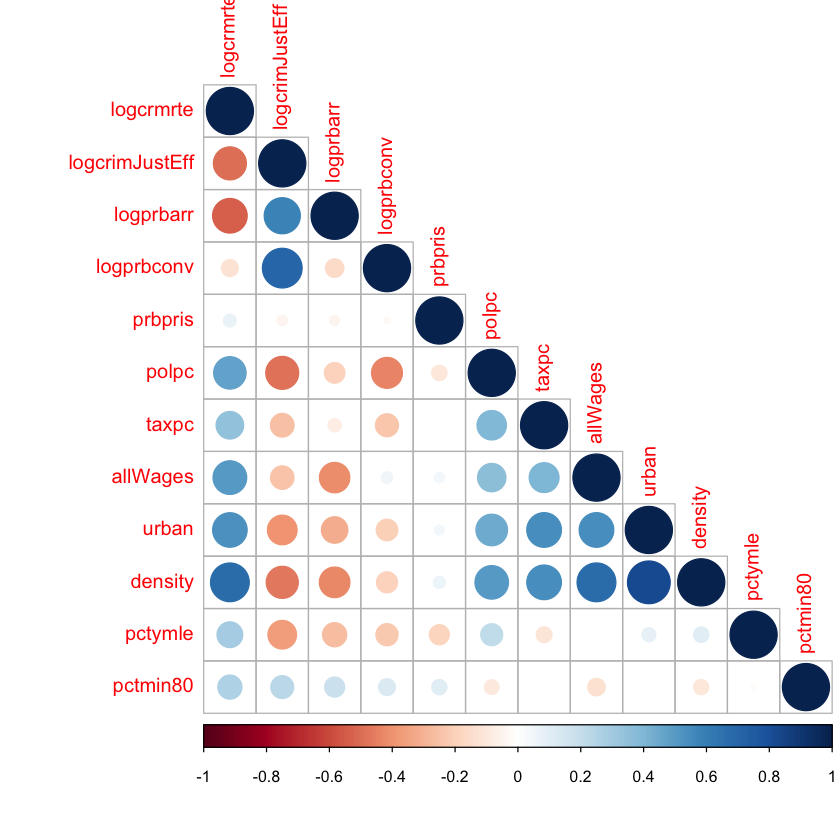

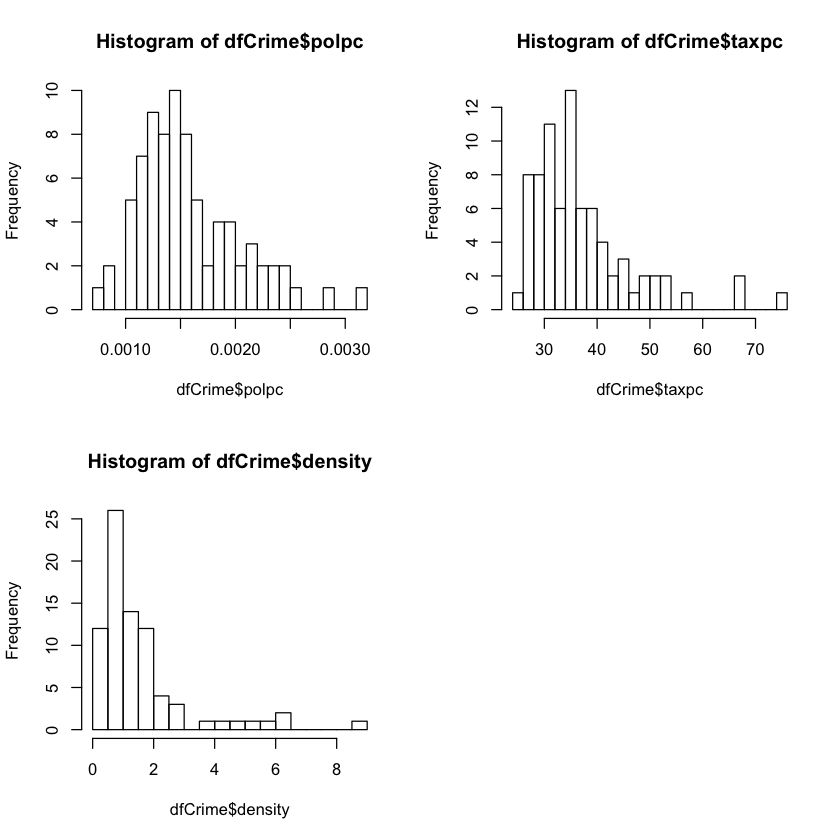

In [315]:
corrplot(cor(dfCrime[,c("logcrmrte", "logcrimJustEff", "logprbarr", "logprbconv", "prbpris", "polpc", "taxpc", "allWages", "urban", "density", "pctymle", "pctmin80")]),method='circle', type = 'lower')

par(mfrow = c(2,2))
hist(dfCrime$polpc, breaks=25)
hist(dfCrime$taxpc, breaks=25)
hist(dfCrime$density, breaks=25)

### Removing Data Outliers
From the histograms above, we can easily see that taxpc has an outlying data point, 119.7615, and as a result, decided to remove this county from our data set. 

In [317]:
dfCrime = dfCrime[dfCrime$taxpc <= 119, ]
# summary(dfCrime$taxpc)
# hist(dfCrime$taxpc)
summary(dfCrime$taxpc)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  25.69   30.92   34.87   37.13   40.02   75.67 

### Data Transformations

In [318]:
dfCrime$logpolpc = log10(dfCrime$polpc)
dfCrime$logtaxpc = log10(dfCrime$taxpc)
dfCrime$logdensity = log10(dfCrime$density)

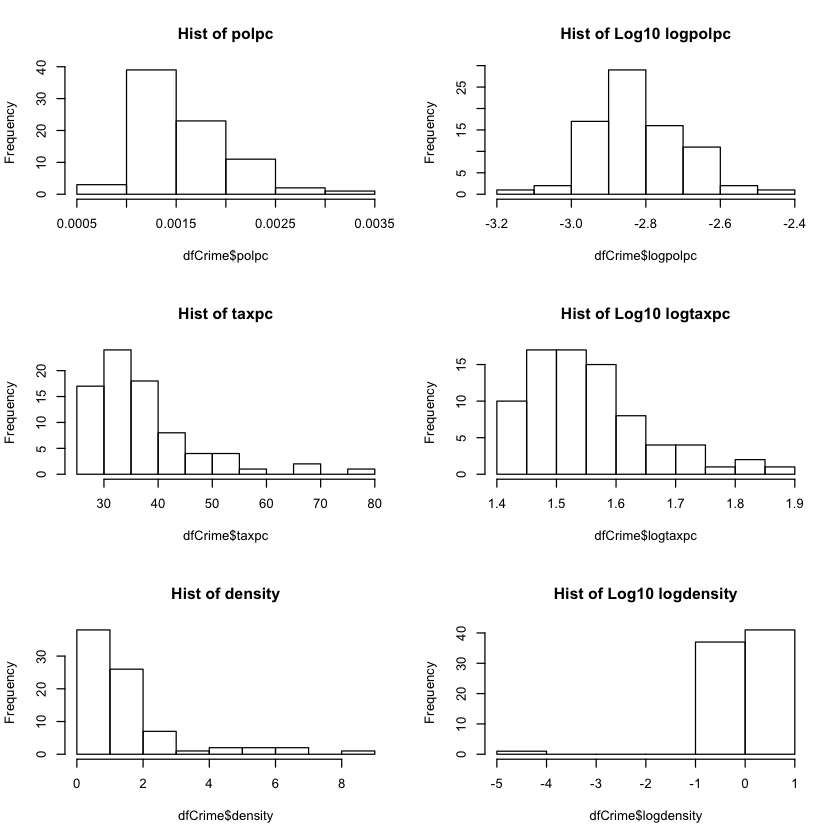

In [320]:
par(mfrow = c(3,2))
hist(dfCrime$polpc, main="Hist of polpc")
hist(dfCrime$logpolpc, main="Hist of Log10 logpolpc")
hist(dfCrime$taxpc, main="Hist of taxpc")
hist(dfCrime$logtaxpc, main="Hist of Log10 logtaxpc")
hist(dfCrime$density, main="Hist of density")
hist(dfCrime$logdensity, main="Hist of Log10 logdensity")

In [307]:
# par(mfrow = c(2,2))
# plot(dfCrime$logcrimJustEff, dfCrime$polpc, main = 'polpc vs logcrimJustEff', xlab='logcrimJustEff', ylab='polpc')
# plot(dfCrime$logcrimJustEff, dfCrime$logpolpc, main = 'logpolpc vs logcrimJustEff', xlab='logcrimJustEff', ylab='logpolpc')
# plot(dfCrime$logcrimJustEff, dfCrime$taxpc, main = 'taxpc vs logcrimJustEff', xlab='logcrimJustEff', ylab='taxpc')
# plot(dfCrime$logcrimJustEff, dfCrime$logtaxpc, main = 'logtaxpc vs logcrimJustEff', xlab='logcrimJustEff', ylab='logtaxpc')

In the histograms above, we see that the both polpc and taxpc exhibit right skew. Taking the $log_{10}$ of polpc brings the distribution closer to normal. However, the $log_{10}$ of taxpc and density makes the distributions even more skewed. 

As a result, we will use the $log_{10}$ of polpc (logpolpc) in our second model and will not transform the taxpc and density variables. 

### Model

In [329]:
model2 <- lm(logcrmrte ~ logcrimJustEff + logpolpc + allWages + taxpc + density, data = dfCrime)
model2

summary(model2)


Call:
lm(formula = logcrmrte ~ logcrimJustEff + logpolpc + allWages + 
    taxpc + density, data = dfCrime)

Coefficients:
   (Intercept)  logcrimJustEff        logpolpc        allWages           taxpc  
    -8.500e-01      -1.607e-01       3.701e-01       6.692e-05      -1.632e-03  
       density  
     6.259e-02  



Call:
lm(formula = logcrmrte ~ logcrimJustEff + logpolpc + allWages + 
    taxpc + density, data = dfCrime)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.43126 -0.08474 -0.00883  0.10997  0.30299 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -8.500e-01  6.214e-01  -1.368 0.175561    
logcrimJustEff -1.607e-01  9.282e-02  -1.731 0.087681 .  
logpolpc        3.701e-01  1.806e-01   2.050 0.043962 *  
allWages        6.692e-05  7.163e-05   0.934 0.353238    
taxpc          -1.632e-03  2.178e-03  -0.749 0.456083    
density         6.259e-02  1.770e-02   3.536 0.000711 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1535 on 73 degrees of freedom
Multiple R-squared:  0.5324,	Adjusted R-squared:  0.5004 
F-statistic: 16.62 on 5 and 73 DF,  p-value: 6.263e-11


The Adjusted R-squared variable penalizes for additional variables, which means there is a chance that this value will decrease if the added variables do not contribute to the model. By comparing the Adjusted R-squared value between our first and second models, we see that log(polpc), taxpc and density help describe log(crmrate). Our second model has an Adjusted R-squared value of 0.5004, which means 50.04% of the variation in the $log_{10}$ of crime rate is explained by the explanatory variables used in this model. This is a significant increase compared to our first model, that has an Adjusted R-squared value of **PUT MODEL 1 R-SQUARED VALUE HERE**. 

In addition, the F-statistic is 16.62 with a statistically significant p-value of < 6.263e-11. As a result, we reject the null hypothesis that none of the independent variables help to descrive log(crmrate). 

Coefficient Analysis:
- logcrimJustEff: -0.1607. This suggests that for a 1% increase in criminal justice efficiency, there is a 0.1607% decrease in crime rate, holding all other factors fixed. 
- logpolpc: 0.3701. This suggests that for a 1% increase in police per capita, there is a 0.3701% increase in crime rate, holding all other factors fixed. 
- allWages: 0.00006692. This suggests that for a 1% increase in total average weekly wage, there is a 0.0067% increase in crime rate, holding all other factors fixed.
- taxpc: -0.001632. This suggests that for a 1% increase in tax per capita, there is a 0.1632% decrease in crime rate, holding all other factors fixed.
- density: 0.06259. This suggests that for a 1% increase in density, there is a 6.259% increase in crime rate, holding all other factors fixed.

### The 6 CLM Assumptions - **WIP**

### Results - **WIP**
- Standard Errors explanation will go here. Placeholder cell for now.


### Conclusion : Are the conclusions they draw based on this evaluation appropriate? Did the team interpret the results in terms of their research question?
Compared to model 1, the adjusted $R^2$ of model 2 is only marginally higher. This suggests that we should continue our analysis by focusing on the join significance of the variables added in model 2.  